# Paper Information
## FurryGAN: High Quality Foreground-aware Image Synthesis

- **Paper Link:** https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136740679.pdf
- **Authors:** Jeongmin Bae, Mingi Kwon, and Youngjung Uh
- **Conference:** ECCV 2022

## Project Group Members
- Batuhan Bal, bal.batuhan@metu.edu.tr
- Onat Özdemir, onat.ozdemir@metu.edu.tr

# Paper Summary

## Introduction

The main motivation of the paper is to design a GAN framework that synthesizes **foreground-aware images**. The proposed framework, FurryGAN, learns to generate images with the explicit awareness of the foreground. In this framework, the authors,
- encourage the foreground and the composite images to resemble the training distribution,
- introduce **coarse and fine masks**. While the coarse mask expresses the rough shape, the fine mask represents the details,
- introduce an auxiliary task for the discriminator to predict the mask from the generated image. The aim of this task is to make the generator produce foreground images aligned with the masks. 

## Method

<p align="center">
    <img src="imgs/framework.png?raw=true"  width="50%" height="50%">
    <p align="center"><b>Figure 1:</b> Proposed Framework</p>
</p>

<br>

As can be seen in **Figure 1**, FurryGAN has three generators: **Foreground Generator**, **Background Generator**, and **Mask Generator**.

- **Foreground Generator ($G_{fg}$):** For a given foreground latent code $z_{fg}$, $G_{fg}$ tries to generate images with realistic foregrounds represented by $x_{fg}$.
- **Background Generator ($G_{bg}$):** For a given background latent code $z_{bg}$, $G_{bg}$ tries to generate images with realistic backgrounds represented by $x_{bg}$. $z_{bg}$ is generated by borrowing the front part of the $z_{fg}$.
- **Mask Generator ($G_{mask}$):** $G_{mask}$ takes the feature maps generated by the $G_{fg}$ and outputs a binary mask that distinguishes the foreground and background parts of the $x_{fg}$. $G_{mask}$ consists of two submodules: **coarse mask generator** and **fine mask generator**. While the coarse mask generator predicts the rough shape of the mask, the fine mask generator tries to catch fine details.

The generators are used for generating composite images according to **Equation 1**.

$$ x_{comp} = m \bullet x_{fg} + (1 - m) \bullet x_{bg} \qquad (1)$$


#### Dual Fake Input Strategy

<p align="center">
    <img src="imgs/architecture.png?raw=true"  width="50%" height="50%">
    <p align="center"><b>Figure 2:</b> Dual Fake Input Strategy and Mask Generators</p>
</p>

With the combination of $x_{fg}$ and $x_{bg}$, FurryGAN generates composite images. However, feeding the discriminator with just these composite images does not guarantee the separation of foreground and background parts, as the mask generator might tend to exclude foreground images from the compositions to mislead the discriminator. 

To overcome this problem, the authors suggest using a dual fake input strategy where the foreground images are also fed into the discriminator. As can be seen in **Figure 2**, for each batch of size N, N/2 of the fake images are the composite images while the remaining N/2 are the foreground images. With this approach, we ensure that the foreground images are realistic by themselves.

#### Coarse and Fine Mask Generators

To distinguish the foreground and background parts of the generated $x_{fg}$, the authors propose to train a mask generator denoted by G_{mask}, which consists of two sub-generator networks: coarse mask generator and fine mask generator. With the coarse mask generator, the motivation is to capture the overall shape, while with the fine mask generator, we aim to capture the fine details such as the hair structure or whiskers of the cats, etc.

$$ m_{coarse} = G_{m_{coarse}}(f) \qquad m_{fine} = G_{m_{fine}}(f) \qquad (2) $$

As can be seen in **Figure 2**, both the coarse mask generator and the fine mask generator take the feature maps generated by $G_{fg}$ as input and produce coarse mask m_{coarse} and fine mask m_{fine} as outputs, respectively.

$$ m = clip(m_{coarse} + \gamma m_{fine}, 0, 1) \qquad (3) $$

The outputs of these mask generators are normalized to the range of [0,1]. The final alpha mask is a weighted summation of these two masks, as shown in **Equation 3**.

#### Discriminator with a mask predictor

The authors use StyleGAN2 architecture for the discriminator. In addition to predicting whether a given image is fake or not, the discriminator contains an auxiliary mask predictor, which predicts a binary mask for given $16\times16$ feature maps. The output of the auxiliary mask predictor $D_{aux}$ is used for calculating the mask prediction and mask consistency losses, which guide the generators.


### Training Objectives

- <font size="4">Adversarial Loss:</font> The adversarial loss is used as a primary objective to achieve foreground-aware image synthesis. The author propose using non-saturating loss for $L^G_{adv}$ and $L^D_{adv}$, and lazy R1-regularization for $L^D_{R1}$.

- <font size="4">Mask Prediction Loss:</font> The auxiliary mask predictor $D_{aux}$ predicts a $16 \times 16$ mask $\hat{m}$ for the generated images. To mask prediction loss is one of the training objectives used for evaluating the masks predicted by $D_{aux}$. A ground-truth mask $m$ is downsampled to $16 \times 16$ using bilinear interpolation. Then, we compare the generated mask to the ground-truth mask using <b>Equation 4</b>.

    $$ L_{pred} = \frac{1}{|\hat{m}|} || Downsample(m) - \hat{m}||^2_{2} \qquad (4) $$

- <font size="4">Mask Consistency Loss:</font> The authors state that during the image composition operation, a part of the foreground image might be removed or additional parts might be added to the composite image. In order for the foreground masks generated for both images to be consistent, the authors propose the use of an additional mask loss called "mask consistency loss". The illustration of this mechanism can be seen in <b>Figure 3</b>.

    <br>

    <p align="center">
        <img src="imgs/mask_consistency_loss_figure.png?raw=true"  width="50%" height="50%">
        <p align="center"><b>Figure 3:</b> Mask Consistency Loss Illustration</p>
    </p>

    <br>

    The mask consistency loss is calculated using **Equation 5**. Here, $\hat{m}_{comp}$ represents the mask predicted for the composite image and $stopgrad$ corresponds to the stop gradient operator.

    $$ L_{consistency} = \frac{1}{|\hat{m}_{comp}|} || D_{aux}(stopgrad(x_{fg})) - \hat{m}_{comp}||^2_{2} \qquad (5) $$


- <font size="4">Coarse Mask Loss:</font>  The authors adopt the binarization loss and the area loss given in <b>Equation 6</b> and <b>Equation 7</b>, respectively. The $\phi_{1}$ given in <b>Equation 7</b> is set to 0.35 for all experiments. The final equation for Coarse Mask Loss is given in <b>Equation 8</b>.

    $$ L_{binary} = \mathbb{E}[min(m_{coarse}, 1 - m_{coarse})] \qquad (6) $$

    $$ L^{coarse}_{area} = max(0, \phi_{1} - \frac{1}{|m_{coarse}|} \sum{}{}m_{coarse}) \qquad (7)$$ 

    $$ L_{m_{coarse}} = L_{binary} + L^{coarse}_{area} \qquad (8) $$

- <font size="4">Fine Mask Loss:</font>  Fine mask predictor aims to capture details like hair, fur, and whiskers. As these details span small areas in a given image, the authors propose using inverse area loss to prevent fine masks to span large areas. The fine mask loss is calculated using <b>Equation 9</b>.

    $$ L_{m_{fine}} = L^{fine}_{area} = max(0, \phi_{2} - \frac{1}{|\hat{m}_{fine}|} \sum{}{}(1 - \hat{m}_{fine}) \qquad (9)$$ 

    Here, $\hat{m}_{fine} = m - m_{coarse}$. In all experiments, $\phi_{2} = 0.01$.

- <font size="4">Background Participation Loss:</font> Similar to the problem mentioned in Mask Consistency Loss, sometimes it is observed that the alpha mask tries to employ the foreground mask excessively. To overcome this issue, the authors propose using Background Participation Loss given in <b>Equation 10</b>, which penalizes the difference between the background image and the composite image.

    $$ L_{reg} = \frac{1}{|x_{comp}|} ||x_{comp} - x_{bg}||^2_2 \qquad (10) $$

- <font size="4">Overall Objective:</font>  Overall objective functions for Discriminator and Generator is given in <b>Equation 11</b> and <b>Equation 12</b>, respectively.

    $$ L^{D}_{total} = L^{D}_{adv} + L^{D}_{R1} + L_{pred} \qquad (11) $$
    $$ L^{G}_{total} = L^{G}_{adv} + L_{consistency} + \lambda_{coarse} L_{m_{coarse}} + \lambda_{fine} L_{m_{fine}} + L_{reg} \qquad (12)$$


# Experimental Goals

## Qualitative Goals

<p align="center">
    <img src="imgs/qualitative_goals.png" width="50%" height="50%">
    <p align="center"><b>Figure 4:</b> Target Qualitative Results</p>
</p>

## Quantitative Goals

<p align="center">
    <img src="imgs/quantitative_goals_1.png"  width="50%" height="50%">
    <img src="imgs/quantitative_goals_2.png"  width="50%" height="50%">
    <p align="center"><b>Figure 6:</b> Target Quantitative Results</p>
</p>

# Code Workflow

- Import Libraries
- Hyperparameters
- Load Dataset
- Train Model
- Save and Load Model
- Generate Qualitative Results
- Generate Quantitative Results

# Import Libraries

In [6]:
%matplotlib inline
import argparse
import os

import torch
import torch.optim as optim

from models import Generator, Discriminator, MaskGenerator
from dataset import load_data
from train import train
from utils import set_fix_seed, save_model, load_model, generate_results, show_image_grid, print_metrics, save_generated_images, load_tracer_masks

import warnings
warnings.filterwarnings("ignore")

set_fix_seed(0)

# Hyperparameters

In [2]:
parser = argparse.ArgumentParser(description='FurryGAN')
args = parser.parse_args(args=[])
args.data_path = "./data"
args.model_save_path = "./models"
args.image_size = 128
args.num_channels = 32
args.max_channels = 128
args.batch_size = 16
args.latent_size = 64
args.style_dim = 128
args.num_iters = 1000
args.lr = 0.002
args.reg_every = 16

args.gamma_start = 0.0
args.gamma_max = 1.0
args.gamma_step = 0.01
args.phi1 = 0.35
args.phi2 = 0.01
args.lambda_coarse = 5.0
args.lambda_fine = 5.0
args.lambda_min = 0.5
args.truncation = 0.7
args.mask_threshold = 0.5
args.r1 = 10.0

args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train and Save the Model

Iteration: 50, Generator Loss: 6.6410, Discriminator Loss: 3.1051
Iteration: 100, Generator Loss: 6.2094, Discriminator Loss: 1.7857
Iteration: 150, Generator Loss: 4.5340, Discriminator Loss: 0.5593
Iteration: 200, Generator Loss: 4.7279, Discriminator Loss: 0.6758
Iteration: 250, Generator Loss: 6.3502, Discriminator Loss: 0.5018
Iteration: 300, Generator Loss: 4.7531, Discriminator Loss: 0.4433
Iteration: 350, Generator Loss: 4.8402, Discriminator Loss: 0.6329
Iteration: 400, Generator Loss: 4.1339, Discriminator Loss: 0.7104
Iteration: 450, Generator Loss: 3.3657, Discriminator Loss: 2.2715
Iteration: 500, Generator Loss: 2.8474, Discriminator Loss: 1.2091
Iteration: 550, Generator Loss: 3.1909, Discriminator Loss: 1.6008
Iteration: 600, Generator Loss: 2.7718, Discriminator Loss: 2.6419
Iteration: 650, Generator Loss: 3.3044, Discriminator Loss: 1.4873
Iteration: 700, Generator Loss: 2.6561, Discriminator Loss: 2.1896
Iteration: 750, Generator Loss: 3.4218, Discriminator Loss: 1.4

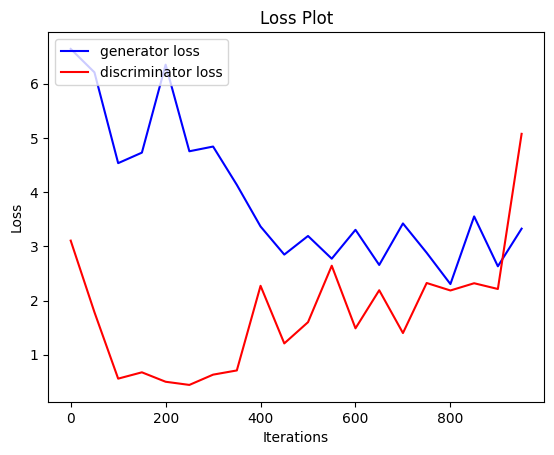

In [3]:
# Load the data
train_loader, test_loader = load_data(args)

# Initialize the models
fg_generator = Generator(args=args, mode="foreground").to(args.device)
bg_generator = Generator(args=args, mode="background").to(args.device)
mask_generator = MaskGenerator(args=args).to(args.device)
discriminator = Discriminator(args=args).to(args.device)

# Initialize the optimizers
regulation_ratio = args.reg_every / (args.reg_every + 1)
generator_params = (
    list(fg_generator.parameters())
    + list(bg_generator.parameters())
    + list(mask_generator.parameters())
)
generator_optim = optim.Adam(
    generator_params,
    lr=args.lr,
    betas=(0.0, 0.99),
)
discriminator_optim = optim.Adam(
    discriminator.parameters(),
    lr=args.lr * regulation_ratio,
    betas=(0.0, 0.99**regulation_ratio),
)

# Train the models
models = [fg_generator, mask_generator, bg_generator]
save_paths = [
    os.path.join(args.model_save_path, "fg_generator.pt"),
    os.path.join(args.model_save_path, "mask_generator.pt"),
    os.path.join(args.model_save_path, "bg_generator.pt"),
]
train(
    fg_generator,
    mask_generator,
    bg_generator,
    discriminator,
    generator_optim,
    discriminator_optim,
    train_loader,
    args,
)

# Save the models
save_model(args, models, save_paths)

# Load the Pretrained Model and Compute the Qualitative Results

The qualitative results displayed in this section aim to generate the Fig. 9 (b).

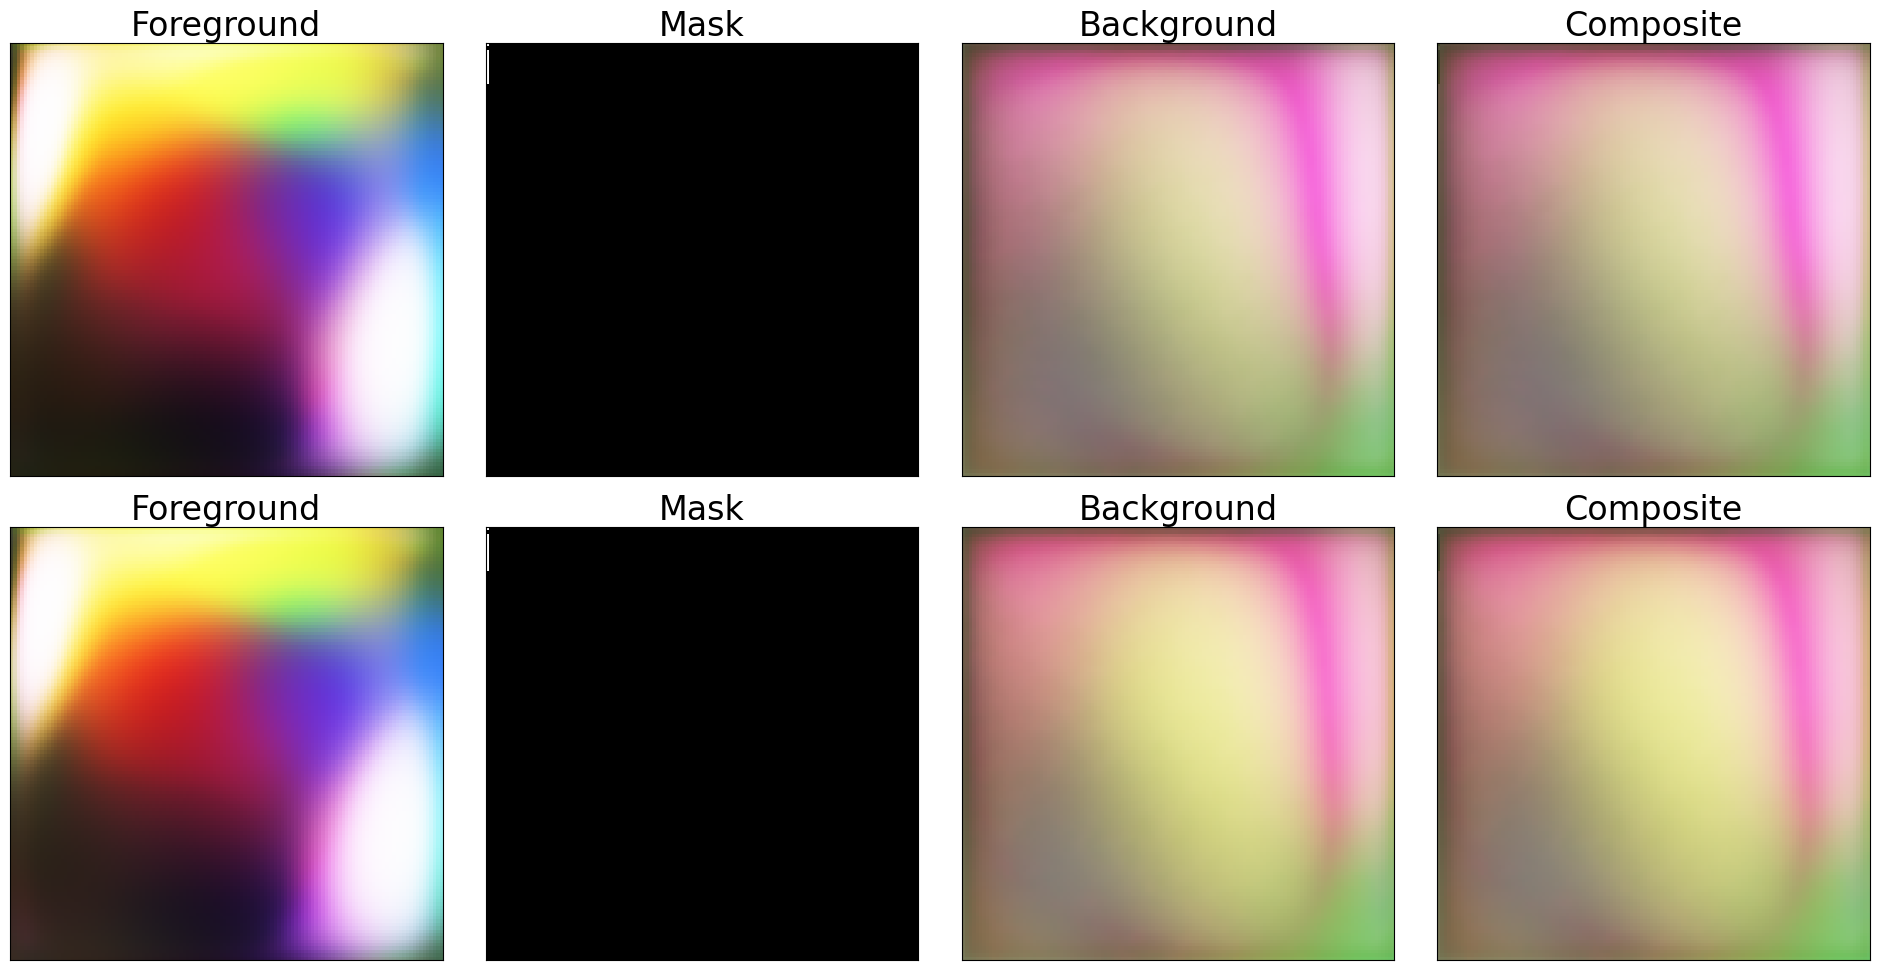

In [10]:
# Initialize the models
fg_generator = Generator(args=args, mode="foreground").to(args.device)
bg_generator = Generator(args=args, mode="background").to(args.device)
mask_generator = MaskGenerator(args=args).to(args.device)
discriminator = Discriminator(args=args).to(args.device)

# Load the models
load_paths = [
    os.path.join(args.model_save_path, "fg_generator.pt"),
    os.path.join(args.model_save_path, "mask_generator.pt"),
    os.path.join(args.model_save_path, "bg_generator.pt"),
]
models = [fg_generator, mask_generator, bg_generator]
load_model(models, load_paths)

# Generate the results
fg_images, masks, bg_images, comp_images = generate_results(
    args, fg_generator, mask_generator, bg_generator, sample_size=2
)

# Show the results
show_image_grid(fg_images, masks, bg_images, comp_images)


# Compute the Quantitative Results

The quantitative results displayed in this section aim to generate Table 2 and Table 3 given in the original paper.

In [11]:
fg_images, masks, bg_images, comp_images = generate_results(
    args, fg_generator, mask_generator, bg_generator, sample_size=args.batch_size
)
save_generated_images(comp_images)

In [12]:
!python ./TRACER/main.py

<----- Initializing inference mode ----->
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b7-4652b6dd.pth
100% 255M/255M [00:03<00:00, 73.8MB/s]
Loaded pretrained weights for efficientnet-b7
Downloading: "https://github.com/Karel911/TRACER/releases/download/v1.0/TRACER-Efficient-7.pth" to /root/.cache/torch/hub/checkpoints/TRACER-Efficient-7.pth
100% 255M/255M [00:03<00:00, 71.5MB/s]
###### pre-trained Model restored #####
test length : 16
100% 4/4 [00:03<00:00,  1.12it/s]
time: 3.587s


In [13]:
gt_fg_masks = load_tracer_masks(args.batch_size)
gt_bg_masks = 1 - gt_fg_masks

real_images = next(iter(test_loader))[0].to(args.device)
fg_masks = masks
bg_masks = 1 - masks
print_metrics(
    real_images, comp_images, gt_fg_masks, fg_masks, gt_bg_masks, bg_masks, args.device
)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 84.4MB/s]


+--------------------+--------+--------+------+--------+-----------+------+----------+
|      Dataset       | fg IoU | bg IoU | mIoU | recall | precision |  F1  | Accuracy |
+--------------------+--------+--------+------+--------+-----------+------+----------+
| AFHQv2-Cat (Ours)  |  0.0   |  1.0   | 0.5  |  nan   |    0.0    | 0.0  |   1.0    |
| AFHQv2-Cat (Paper) |  0.95  |  0.87  | 0.91 |  0.98  |    0.97   | 0.97 |   0.95   |
+--------------------+--------+--------+------+--------+-----------+------+----------+
+--------------------+--------+
|      Dataset       |  FID   |
+--------------------+--------+
| AFHQv2-Cat (Ours)  | 305.58 |
| AFHQv2-Cat (Paper) |  6.34  |
+--------------------+--------+


# Difficulties Encountered

- The paper does not provide some details about the changes that are made to the original StyleGAN2 architecture. For example, they  mentioned that they used shallower version of the mapping network, but they did not provide the details of the architecture of the mapping networks. So, we had to make following assumptions:
    - The mapping networks have 4 layers instead of 8 layers.
    - The number of channels in the mapping networks is 128 instead of 512.
- The paper does not provide some details of the discriminator architecture. For example, dimension of input style vector is not mentioned. So, we assumed that the dimension of the input style vector is 128.
- The paper does not mention path length regularization. So, we did not use it.
- In the paper, the authors had calculated IoU for the foreground and background masks separately. However, we could not understand the meaning of background mask. So, we calculated background mask as (1 - foreground) mask.

# Effort and Ideas
- We incorporated skip connections into the architecture, which were excluded in the original paper.

- Additionally, we increased the complexity of the mapping network to its original archtiecture, instead of using shallow mapping network mentioned in the paper.

- We conducted extensive experiments by exploring various combinations and weights for the losses used in the model. This allowed us to identify the most effective configuration for achieving the desired results.


- During our experimentation, we observed that the discriminator was converging at a faster rate compared to the generator. To address this, we experimented with different learning rates for both models, aiming to achieve a better balance and ensure optimal training dynamics.

- Lastly, we try to fit the model on small dataset to overfit, but that did not work either.